In [1]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose, UpSampling2D
# from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.layers import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
# from keras.engine.saving import load_model
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import img_to_array, load_img
from skimage.transform import resize


import keras.backend as K

import matplotlib.pyplot as plt
import os
import sys
import numpy as np

%pylab inline

from PIL import Image
from tqdm import tnrange, tqdm_notebook, tqdm
import cv2
import random

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.linear_model import LogisticRegression
import random
from tqdm.notebook import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['resize']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# Model parameters

# Program will grab 100 epoch weights for G,D in ./Output/trained_model_name/
# trained_model_name = "lsun_colorization_full_model"
# trained_model_name = "places2_colorization_read_imgs_flow_test"
trained_model_name = "places2_final_k_1_with_noise"
# trained_model_name = 'ablation_circles_equal_l_k_3_no_noise_no_aug'

# Program will save output in ./TestOutput/trained_model_name by default
# Change from none to save output in ./TestOutput/overwrite_save_dir
# overwrite_save_dir = "WHJ_Predictions"
# overwrite_save_dir = "LSUN_on_places2"
overwrite_save_dir = None

# Should output have the same file names as the test images?
preserve_img_names = True

# Must match k from model
k = 1

# Testing parameters
num_test_imgs = 64

# Should program randomly colorize some test images and leave some ground truth?
# This was used to generate data for a user study
random_select_gt_or_colorzed = False

# Specify what dataset to test on
# dataset = 'circle_pairs_equal_l_red_blue/'
# dataset = 'new_circles/'
# dataset = '../Colorization_GAN/circle_pairs/'
# test_dataset = 'lsun/test/'
test_dataset = 'OutputDataset/'
train_dataset = 'places2/test/'
# test_dataset = 'places2/10_imgs_per_cat/'
# dataset = 'William_Henry_Jackson/WHJ_Resized_Square/'

In [3]:
def list_image_files(directory):
    files = sorted(os.listdir(directory))
    return [os.path.join(directory, f) for f in files if is_an_image_file(f)]

In [4]:

def is_an_image_file(filename):
    IMAGE_EXTENSIONS = ['.png', '.jpg', '.jpeg']
    for ext in IMAGE_EXTENSIONS:
        if ext in filename:
            return True
    return False

In [5]:
def load_image(path):
    img = cv2.imread(path[0])
    
    # Make sure all images are 256 x 256 by cropping them
    r, c = img.shape[:2]
    r_diff = (r - 256) // 2
    c_diff = (c - 256) // 2
    cropped = img[r_diff:256 + r_diff, c_diff:256 + c_diff] 
    return cropped

In [6]:
def load_images(path, n_images=-1, shouldShuffle=False):
    all_image_paths = list_image_files(path)
    if shouldShuffle:
        random.shuffle(all_image_paths)
    
    if n_images < 0:
        n_images = len(all_image_paths)
    images_l, images_ab = [], []
    
    # Initialize a progress bar with max of n_images
    pbar = tqdm(total = n_images, desc="Loading Images...")
    
    for path in zip(all_image_paths):
        img = load_image(path)
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        lab_img = preprocess_image(lab_img)
        
        l = lab_img[:,:,0]
        l = l[:,:,np.newaxis]
        # Include all 3 channels, overwrite 1st channel with 0's
        ab = lab_img[:,:,1:]

        images_l.append(l)
        images_ab.append(ab)

        images_loaded = len(images_l)
        
        # Increase progress by one
        pbar.update(1)
        
        if images_loaded > n_images - 1: 
            break

    return {
        'l': np.array(images_l),
        'ab': np.array(images_ab)
    }

In [7]:
RESHAPE = (256,256)

def preprocess_image(cv_img):
    img = (cv_img - 127.5) / 127.5
    return img

def deprocess_image(img):
    img = (img * 127.5) + 127.5
    return img.astype('uint8')

In [8]:
def save_image(np_arr, path):
    img = np_arr * 127.5 + 127.5
    im = Image.fromarray(img)
    im.save(path)

In [9]:
def get_generator(H, W, k):
    # Inputs: height and width of the input image
    # Returns the model, which generates the AB channels

    # Pix2pix adapted from 
    # https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py

    def conv2d(layer_input, filters, f_size=4, bn=True):
        """Layers used during downsampling"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input])
        return u

    gf = 64 # Number of filters in the first layer of G

    noise_in = Input(shape=(100,))
    condition_in = Input(shape=(H, W, 1))
    
    # pass noise through a FC layer to get it to the right size
    noise = Dense(H * H)(noise_in)

    # reshape to be the size of an image channel
    noise = Reshape((H, H, 1))(noise)
    
    # stick the (somewhat modified) noise as the second channel after
    # the gray input. Assuming new dimension of hid will be
    # B x 256 x 256 x 2, where B is the batch size.
    d0 = Concatenate(axis=-1)([condition_in, noise])
#     d0 = condition_in # Don't need noise since it's being ignored anyway

    # U-NET
    # Downsampling
    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4)
    d4 = conv2d(d3, gf*8)
    d5 = conv2d(d4, gf*8)
    d6 = conv2d(d5, gf*8)
    d7 = conv2d(d6, gf*8)

    # Upsampling
    u1 = deconv2d(d7, d6, gf*8)
    u2 = deconv2d(u1, d5, gf*8)
    u3 = deconv2d(u2, d4, gf*8)
    u4 = deconv2d(u3, d3, gf*4)
    u5 = deconv2d(u4, d2, gf*2)
    u6 = deconv2d(u5, d1, gf)

    u7 = UpSampling2D(size=2)(u6)
    
    # Final 2-channel AB image with values between -1 and 1
    img_out = Conv2D(2*k, kernel_size=4, strides=1, padding='same', activation='tanh', name='pred_ab')(u7)

    # Make Model
    model = Model(inputs=[noise_in, condition_in], outputs=img_out)
    
    # Show summary of layers
    print("Generator Model:")
    model.summary()

    return model


In [10]:
def get_discriminator(H, W, k):
    # Inputs: height and width of the input image
    # Returns the model, which predicts real/fake
    # over a set of spatial regions (i.e., predicts a matrix instead of a scalar).

    # Pix2pix adapted from re454
    # https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py

    def d_layer(layer_input, filters, f_size=4, bn=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    # Number of filters in the first layer of D
    df = 64

    img_in = Input(shape=(H, W, 2*k)) # AB channels
    condition_in = Input(shape=(H, W, 1)) # L channel
    
    # Concat the L and AB channels
    concat_imgs = Concatenate()([condition_in, img_in])

    d1 = d_layer(concat_imgs, df, bn=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)

    # validity map is a one-channel matrix 1/16 the size of the input (halved 4 times).
    # Each number predicts whether a region of the input is real/fake.
    validity = Conv2D(1*k, kernel_size=4, strides=1, padding='same', name='pred_valid')(d4)

    # Build Model
    model = Model(inputs=[img_in, condition_in], outputs=validity)

    # Show summary of layers
    print("Disciminator Model:")
    model.summary()

    return model

In [11]:
def min_k_diff(y_true, y_pred):
    # Shape: (Batch, H, W, k, 2)
    y_true = K.reshape(y_true, (-1, H, W, k, 2))
    y_pred = K.reshape(y_pred, (-1, H, W, k, 2))

    print("true:", y_true.shape)
    print("pred:", y_pred.shape)

    diff = y_true - y_pred
    diff = K.abs(diff)
    diff = K.mean(diff, axis=(1, 2, 4)) # mean of (H, W, 2) leaves (B, k)
    
    loss_metric = diff

    min_for_each_batch = K.min(loss_metric, axis=1)
    return K.sum(min_for_each_batch) #* .01

In [12]:
from keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

In [13]:
def save_rgb_img(l, ab, filename):
    # Make sure ab is the right type, generated imgs change to float32
    ab = ab.astype(np.float64)
    
    # Merge
    merged = cv2.merge((l, ab))
    
    # Get between 0, 255
    deprocessed = deprocess_image(merged)
    
    # Change to BGR (Curse you CV2!!!)
    rgb = cv2.cvtColor(deprocessed, cv2.COLOR_LAB2BGR)
    
    # Save
    cv2.imwrite(save_path + filename, rgb)

In [14]:
def make_discrim_models():
    # Load training data
    max_imgs = 2500
    if len(list_image_files(train_dataset)) > max_imgs:
        num_imgs = max_imgs
    else:
        num_imgs = -1

    train_data = load_images(train_dataset, num_imgs, True)
    train_l, train_ab = train_data['l'], train_data['ab']

    # Make generated data
    noise = generate_noise(len(train_l), 100)
    train_predictions = generator.predict([noise, train_l])

    # Tile truth data
    tiled = np.tile(train_ab, k)

    # Make discrim predictions
    generated_discrim_values = discriminator.predict([train_predictions, train_l])
    true_discrim_values = discriminator.predict([tiled, train_l])
    
    # Flatten discrim values
    n = generated_discrim_values.shape
    flat_gen_discrim_val = generated_discrim_values.reshape((n[0], n[1] * n[2], n[3]))
    flat_true_discrim_val = true_discrim_values.reshape((n[0], n[1] * n[2], n[3]))
    
    # Make labels
    model_labels = np.concatenate((np.zeros(len(generated_discrim_values)), np.ones(len(true_discrim_values))))
    
    # Loop through and store models
    models = []
    for i in range(k):
        model_data = np.concatenate((flat_gen_discrim_val[:,:,i], flat_true_discrim_val[:,:,i]))
        model = LogisticRegression(max_iter=1000).fit(model_data, model_labels)
        models.append(model)
        
    return models

In [15]:
# Find where model is located
#saved_GAN_location = "OutputDataset_final_k_1_with_noise/" + trained_model_name + "/GAN_Weights_Epoch_100.weight.h5"
#saved_D_location = "OutputDataset_final_k_1_with_noise/" + trained_model_name + "/Discriminator_Weights_Epoch_100.weight.h5"

saved_GAN_location = "GAN_Weights_Epoch_100.weights.h5"
saved_D_location = "Discriminator_Weights_Epoch_100.weights.h5"

# Create folder to store output
generic_output_folder = "Test_Output/"

if overwrite_save_dir is None:
    new_output_folder = trained_model_name + "/"
    save_path = generic_output_folder + new_output_folder
else:
    save_path = generic_output_folder + overwrite_save_dir + "/"
    
if random_select_gt_or_colorzed:
    save_path += "random_colorized_or_ground_truth/"
else:
    save_path += "all_predictions/"

# Ensure output can save in desired location
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [16]:
# ===================================
# COULD NOT HANDLE LARGE TRAINING SET
# ===================================

from tqdm.notebook import tqdm
# Get training images
# Load dataset, convert to LAB, normalize to range [-1, 1]
# data = load_images(dataset + 'test', num_test_imgs)
# data = load_images(dataset + "/test/", num_test_imgs)
data = load_images(test_dataset, num_test_imgs)



# Only want l channel
l_channel_imgs, ab_channel_imgs = data['l'], data['ab']

Loading Images...:   0%|          | 0/64 [00:00<?, ?it/s]

In [17]:
# GAN creation
H = W = 256

# Discriminator loss - MSE seems to produce better results
#discrim_loss = 'binary_crossentropy'
discrim_loss = 'mse'

# 1. Discriminator
# Calculate output shape of D (PatchGAN)
patch = H // 2**4 # Input size gets cut in half 4 times
discriminator = get_discriminator(H, W, k)
discriminator.name = 'discrim_model' # Need a name for the loss dictionary below
discriminator.compile(optimizer=Adam(2e-4, 0.5), loss=discrim_loss, metrics=['accuracy'])
discriminator.trainable = False # For the combined model we will only train the generator
print("\n")

# 2. Generator
generator = get_generator(H, W, k)
generator.name = 'gen_model' # Need a name for the loss dictionary below

# 3. GAN
gan_noise_in = Input(shape=(100,))
gan_condition_in = Input(shape=(H, W, 1))

# By conditioning on L generate a fake version of AB
fake_AB = generator([gan_noise_in, gan_condition_in])

# Discriminator determines validity of AB images / L pairs
print("fake_ab:", fake_AB.shape)

print("gan_condition_in:", gan_condition_in.shape)

valid = discriminator([fake_AB, gan_condition_in])

losses = {'gen_model': min_k_diff, # used to be 'gen_loss'
          'discrim_model': discrim_loss}
loss_weights = {'gen_model': 100.0, 'discrim_model': 1.0}

gan = Model(inputs=[gan_noise_in, gan_condition_in], outputs=[fake_AB, valid])
gan.compile(optimizer=Adam(2e-4, 0.5), loss=losses, loss_weights=loss_weights)
gan.summary()

Disciminator Model:


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer (InputLayer)      │ (None, 256, 256, 2)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 256, 256, 3)       │               0 │ input_layer_1[0][0],       │
│                               │                           │                 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 64)      │           3,136 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 128, 128, 64)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 64, 64, 128)       │         131,200 │ leaky_re_lu[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 64, 64, 128)       │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 64, 64, 128)       │             512 │ leaky_re_lu_1[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 32, 32, 256)       │         524,544 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)     │ (None, 32, 32, 256)       │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 32, 256)       │           1,024 │ leaky_re_lu_2[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 16, 16, 512)       │       2,097,664 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU)     │ (None, 16, 16, 512)       │               0 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 16, 16, 512)       │           2,048 │ leaky_re_lu_3[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pred_valid (Conv2D)           │ (None, 16, 16, 1)         │           8,193 │ batch_normalization_2[0][… │
└───────────────────────────────┴───────────────────────────┴───────────────

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)



Generator Model:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 65536)             │       6,619,136 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 256, 256, 1)       │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 256, 256, 2)       │               0 │ input_layer_3[0][0],       │
│                               │                           │                 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 128, 128, 64)      │           2,112 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU)     │ (None, 128, 128, 64)      │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 128)       │         131,200 │ leaky_re_lu_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU)     │ (None, 64, 64, 128)       │               0 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 64, 64, 128)       │             512 │ leaky_re_lu_5[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 256)       │         524,544 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU)     │ (None, 32, 32, 256)       │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 32, 32, 256)       │           1,024 │ leaky_re_lu_6[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 16, 16, 512)       │       2,097,664 │ batch_normalization_4[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU)     │ (None, 16, 16, 512)       │               0 │ conv2d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_5         │ (None, 16, 16, 512)       │           2,04

 Total params: 48,459,394 (184.86 MB)

 Trainable params: 48,450,562 (184.82 MB)

 Non-trainable params: 8,832 (34.50 KB)

fake_ab: (None, 256, 256, 2)
gan_condition_in: (None, 256, 256, 1)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 256, 256, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gen_model (Functional)        │ (None, 256, 256, 2)       │      48,459,394 │ input_layer_4[0][0],       │
│                               │                           │                 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ discrim_model (Functional)    │ (None, 16, 16, 1)         │       2,768,321 │ gen_model[0][0],           │
│                               │                           │                 │ input_layer_5[0][0]        │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 51,227,715 (195.42 MB)

 Trainable params: 48,450,562 (184.82 MB)

 Non-trainable params: 2,777,153 (10.59 MB)

In [18]:
# saved_GAN_location = "Output/places2_final_k_1_with_noise/GAN_Weights_Epoch_100.h5"
print(saved_GAN_location)
print(saved_D_location)

GAN_Weights_Epoch_100.weights.h5
Discriminator_Weights_Epoch_100.weights.h5


In [19]:
# Load the weights
discriminator.load_weights(saved_D_location)
gan.load_weights(saved_GAN_location)

print("Model loaded")

Model loaded


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 110 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [20]:
noise = generate_noise(len(l_channel_imgs), 100)

# colorized_predictions is [num_test_imgs, k]
colorized_predictions = generator.predict([noise, l_channel_imgs])

print("Predictions for", len(colorized_predictions), "images complete!")

2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 8s/step
Predictions for 64 images complete!


In [21]:
save_path

'Test_Output/places2_final_k_1_with_noise/all_predictions/'

In [22]:
if random_select_gt_or_colorzed:
    # Make models so we can determine best prediction given discrim value
    print("Building models...")
    models = make_discrim_models()
    
    # Get discrim values and reshape
    print("Making discrim predictions...")
    discrim_values = discriminator.predict([colorized_predictions, l_channel_imgs])
    print("Predictions complete!\n")
    n = discrim_values.shape
    reshaped_predictions_discrim = discrim_values.reshape((n[0], n[1]*n[2], n[3]))

    # Get probabilities for each k
    print("Testing each k...")
    probs = []
    for i in range(k):
        k_discrim_value = reshaped_predictions_discrim[:,:,i]
        prob = models[i].predict_proba(k_discrim_value)
        probs.append(prob[:,1])
        print("k =", i, "complete!")
        
    # Store best prediction index
    best_prediction_indices = np.argmax(np.array(probs), 0)
    
    print('best_prediction_indices:', best_prediction_indices)

In [23]:
print("Merging, deprocessing, converting to RGB, and saving images")

num_ground_truth_selected = 0
original_img_names = list_image_files(test_dataset)

# Loop through images that were colorized
for i, img in enumerate(colorized_predictions):
    if preserve_img_names:
        img_name = original_img_names[i]
        filename = img_name.split("/")[-1].split(".")[0]
    else:
        filename = str(i+1).zfill(len(str(num_test_imgs)))

    # For each img, use either ground truth or random colorized prediction
    if random_select_gt_or_colorzed:
        # Determine whether to use ground truth or prediction
        use_ground_truth = random.choice([True, False])
        
        # Either use ground truth or best prediction
        if use_ground_truth:
            num_ground_truth_selected += 1
            filename += "_Ground_Truth.png"
            save_rgb_img(l_channel_imgs[i], ab_channel_imgs[i], filename)
        else:
            prediction_i = best_prediction_indices[i]
            filename += "_Colorized_.png"
            prediction = img[:,:,2*prediction_i:2*prediction_i+2]
            save_rgb_img(l_channel_imgs[i], prediction, filename)
    else:
        # Save original
        save_rgb_img(l_channel_imgs[i], ab_channel_imgs[i], filename + " original.png")
        # Save grayscale
        gray = np.zeros((256, 256, 2))
        save_rgb_img(l_channel_imgs[i], gray, filename + " grayscale.png")
        
        # Loop through predictions
        for j in range(k):
            prediction = img[:,:,2*j:2*j+2]
            save_rgb_img(l_channel_imgs[i], prediction, filename + "-" + str(j+1) + ".png")
            
    if (i + 1) % 25 == 0:
        print("--", i+1, "completed")
        
print("DONE!")

if random_select_gt_or_colorzed:
    print("\nBreakdown of Ground Truth vs. Colorized Selected:")
    print("Ground Truth:", num_ground_truth_selected, "--", str(100 * num_ground_truth_selected / len(l_channel_imgs)) + "%")
    print("Colorized:", len(l_channel_imgs) - num_ground_truth_selected, "--", str(100 * (len(l_channel_imgs) - num_ground_truth_selected) / len(l_channel_imgs)) + "%")

Merging, deprocessing, converting to RGB, and saving images
-- 25 completed
-- 50 completed
DONE!


(1, 256, 256, 2)


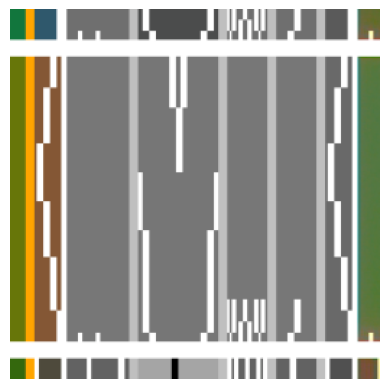

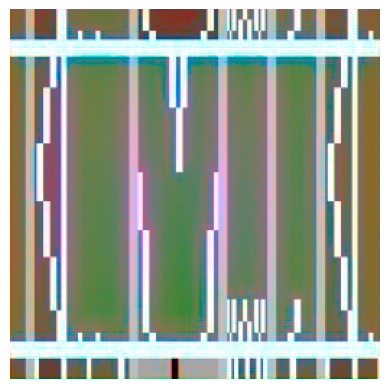

In [24]:
# Each k has its own discrim model

pred = colorized_predictions[:1, :, :, :6]
print(pred.shape)

disp = deprocess_image(cv2.merge((l_channel_imgs[0], ab_channel_imgs[0])))
disp = cv2.cvtColor(disp, cv2.COLOR_LAB2RGB)
plt.figure()
plt.imshow(disp)
plt.axis('off')
plt.show()
 
disp = deprocess_image(cv2.merge((l_channel_imgs[0], pred[0].astype(np.float64))))
disp = cv2.cvtColor(disp, cv2.COLOR_LAB2RGB)
plt.figure()
plt.imshow(disp)
plt.axis('off')
plt.show()
 
# three_of_same = np.zeros((1, 256, 256, 6))
# three_of_same[:, :, :, :2] += pred
# three_of_same[:, :, :, 2:4] += pred
# three_of_same[:, :, :, 4:] += pred

# three_of_same[:, :, :, 4:].shape
# print(three_of_same.shape)

# discrim_score = discriminator.predict([three_of_same, l_channel_imgs[:1]])
# discrim_score = discriminator.predict([three_of_same, l_channel_imgs[:1]])
# discrim_score = discriminator.predict([colorized_predictions, l_channel_imgs])
# for x in range(1):
#     plt.figure()
#     plt.imshow(discrim_score[0, :, :, x])
#     plt.colorbar()
#     plt.show()

In [25]:
# # Fungsi untuk menghitung aktivasi model InceptionV3 dari kumpulan gambar
# def calculate_inception_activations(images):
#     model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
#     processed_images = preprocess_input(images)
#     activations = model.predict(processed_images)
#     return activations

In [26]:
# # Fungsi untuk menghitung FID Score antara dua sets gambar
# def calculate_fid(model, images1, images2):
#     act1 = calculate_inception_activations(images1)
#     act2 = calculate_inception_activations(images2)
#     mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
#     mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
#     ssdiff = np.sum((mu1 - mu2) ** 2.0)
#     covmean = sqrtm(sigma1.dot(sigma2))
#     if np.iscomplexobj(covmean):
#         covmean = covmean.real
#     fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
#     return fid

In [27]:
# # Fungsi untuk memuat dan menyiapkan gambar
# def load_and_preprocess_images(image_paths):
#     images = []
#     for image_path in image_paths:
#         image = load_img(image_path, target_size=(299, 299))
#         image = img_to_array(image)
#         images.append(image)
#     images = np.array(images)
#     return images

In [29]:
# images1 = load_and_preprocess_images(image_paths1)
# images2 = load_and_preprocess_images(image_paths2)

# fid_score = calculate_fid(None, images1, images2)
# print('FID score:', fid_score)